### <b>전이 학습(Transfer Learning)을 활용한 인공지능 서비스 만들기</b>

* 본 프로젝트에서는 상용 인공지능 서비스를 제작합니다.
    1. 이미지 크롤링(image crawling) 혹은 크롤링 라이브러리
    2. 전이 학습(transfer learning)
* 이 프로젝트에서 만들어 볼 것은 <b>stylegan3,real_image</b> 분류기(classifier)입니다.
* 인공지능 개발 과정
    * 데이터 수집/정제
    * 인공지능 모델 학습
   
* 한글 폰트 설치할 경우  <b>[런타임] - [런타임 다시 시작]</b>을 수행해야함.

In [1]:
# 한글 폰트 설치하기 (꼭! 설치가 완료되면 [런타임 다시 시작]을 누르고 다시 실행하기)
!apt install fonts-nanum -y

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 한글 폰트 설정하기
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=10)
plt.rc('font', family='NanumBarunGothic')
matplotlib.font_manager._rebuild()

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.


In [3]:
import os
import shutil

#from bing_image_downloader.bing_image_downloader import downloader


directory_list = [
    './custom_dataset/train/',
    './custom_dataset/test/',
]

# 초기 디렉토리 만들기
for directory in directory_list:
    if not os.path.isdir(directory):
        os.makedirs(directory)

# 수집한 이미지를 학습 데이터와 평가 데이터로 구분하는 함수
def dataset_split(query, train_cnt):
    # 학습 및 평가 데이터셋 디렉토리 만들기
    for directory in directory_list:
        if not os.path.isdir(directory + '/' + query):
            os.makedirs(directory + '/' + query)
    # 학습 및 평가 데이터셋 준비하기
    cnt = 0
    for file_name in os.listdir(query):
        if cnt < train_cnt:
            print(f'[Train Dataset] {file_name}')
            shutil.move(query + '/' + file_name, './custom_dataset/train/' + query + '/' + file_name)
        else:
            print(f'[Test Dataset] {file_name}')
            shutil.move(query + '/' + file_name, './custom_dataset/test/' + query + '/' + file_name)
        cnt += 1
    shutil.rmtree(query)

#### <b>1. 이미지 크롤링을 활용한 학습 이미지 수집</b>

* 수집한 이미지를 저장하기 위한 폴더를 생성하고, 필요한 함수를 정의합니다.



##돌려야 하는 부분

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [18]:
# 위치는 크롤링하고자하는 데이터의 상위 폴더로 이동해주어야함
%cd train

/content/custom_dataset/train


In [19]:
%ls

real_image/  stylegan3/


test와 train 폴더에 각각 stylegan3 , real image 폴더 생성해주어야함. 
train용 사진과 test용 사진 나눠서 업로드 해줄 것.

In [20]:
## 이미지 데이터 크롤링 과정

query = 'stylegan3'

dataset_split(query, 30)

[Train Dataset] 0181.png
[Train Dataset] 0141.png
[Train Dataset] 0184.png
[Train Dataset] 0154.png
[Train Dataset] 0099.png
[Train Dataset] 0169.png
[Train Dataset] 0166.png
[Train Dataset] 0048.png
[Train Dataset] 0193.png
[Train Dataset] 0161.png
[Train Dataset] 0069.png
[Train Dataset] 0109.png
[Train Dataset] 0094.png
[Train Dataset] 0002.png
[Train Dataset] 0121.png
[Train Dataset] 0122.png
[Train Dataset] 0068.png
[Train Dataset] 0147.png
[Train Dataset] 0177.png
[Train Dataset] 0037.png
[Train Dataset] 0032.png
[Train Dataset] 0051.png
[Train Dataset] 0110.png
[Train Dataset] 0066.png
[Train Dataset] 0012.png
[Train Dataset] 0084.png
[Train Dataset] 0157.png
[Train Dataset] 0090.png
[Train Dataset] 0075.png
[Train Dataset] 0041.png
[Test Dataset] 0070.png
[Test Dataset] 0020.png
[Test Dataset] 0011.png
[Test Dataset] 0085.png
[Test Dataset] 0190.png
[Test Dataset] 0078.png
[Test Dataset] 0203.png


In [21]:
query = 'real_image'

dataset_split(query, 30)

[Train Dataset] 00071.png
[Train Dataset] 00019.png
[Train Dataset] 00090.png
[Train Dataset] 00001.png
[Train Dataset] 00076.png
[Train Dataset] 00131.png
[Train Dataset] 00104.png
[Train Dataset] 00107.png
[Train Dataset] 00046.png
[Train Dataset] 00086.png
[Train Dataset] 00100.png
[Train Dataset] 00009.png
[Train Dataset] 00129.png
[Train Dataset] 00113.png
[Train Dataset] 00092.png
[Train Dataset] 00074.png
[Train Dataset] 00095.png
[Train Dataset] 00056.png
[Train Dataset] 00055.png
[Train Dataset] 00014.png
[Train Dataset] 00025.png
[Train Dataset] 00036.png
[Train Dataset] 00034.png
[Train Dataset] 00045.png
[Train Dataset] 00103.png
[Train Dataset] 00011.png
[Train Dataset] 00023.png
[Train Dataset] 00091.png
[Train Dataset] 00094.png
[Train Dataset] 00022.png
[Test Dataset] 00037.png
[Test Dataset] 00030.png
[Test Dataset] 00017.png
[Test Dataset] 00081.png
[Test Dataset] 00067.png
[Test Dataset] 00073.png
[Test Dataset] 00018.png


#### <b>2. PyTorch를 이용한 전이 학습(Transfer Learning)</b>

* 전이 학습(transfer learning)의 동작 과정을 간략화한 것은 다음과 같습니다.

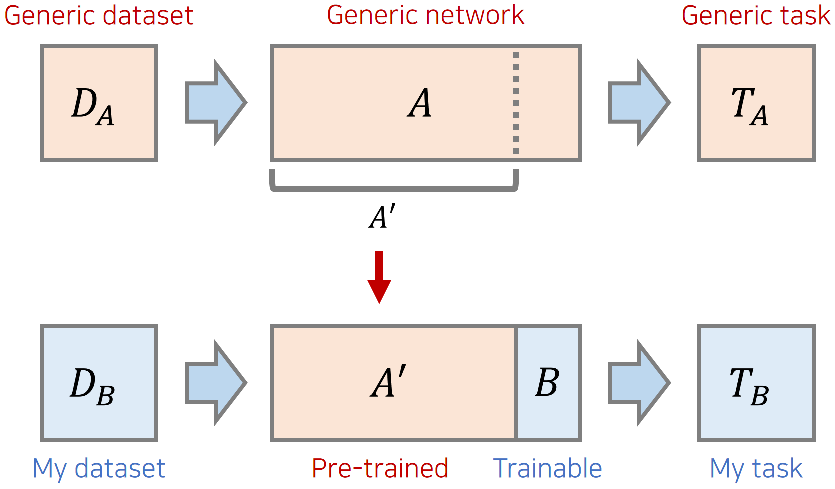

* 학습을 위해 필요한 라이브러리를 불러옵니다.

In [22]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
from torchvision import datasets, models, transforms

import numpy as np
import time


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # device 객체

* 데이터셋을 불러옵니다.

In [24]:
# 데이터셋을 불러올 때 사용할 변형(transformation) 객체 정의
transforms_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(), # 데이터 증진(augmentation)
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # 정규화(normalization)
])

transforms_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

data_dir = './custom_dataset'
train_datasets = datasets.ImageFolder(os.path.join(data_dir, 'train'), transforms_train)
test_datasets = datasets.ImageFolder(os.path.join(data_dir, 'test'), transforms_test)

train_dataloader = torch.utils.data.DataLoader(train_datasets, batch_size=4, shuffle=True, num_workers=4)
test_dataloader = torch.utils.data.DataLoader(test_datasets, batch_size=4, shuffle=True, num_workers=4)

print('학습 데이터셋 크기:', len(train_datasets))
print('테스트 데이터셋 크기:', len(test_datasets))

class_names = train_datasets.classes
print('클래스:', class_names)

학습 데이터셋 크기: 60
테스트 데이터셋 크기: 14
클래스: ['real_image', 'stylegan3']


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


* 간단히 이미지를 시각화해 봅시다.

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


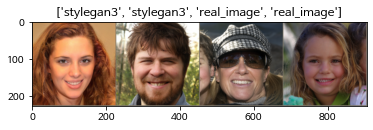

In [25]:
def imshow(input, title):
    # torch.Tensor를 numpy 객체로 변환
    input = input.numpy().transpose((1, 2, 0))
    # 이미지 정규화 해제하기
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    input = std * input + mean
    input = np.clip(input, 0, 1)
    # 이미지 출력
    plt.imshow(input)
    plt.title(title)
    plt.show()


# 학습 데이터를 배치 단위로 불러오기
iterator = iter(train_dataloader)

# 현재 배치를 이용해 격자 형태의 이미지를 만들어 시각화
inputs, classes = next(iterator)
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

* 학습할 CNN 딥러닝 모델 객체를 초기화합니다.

In [26]:
model = models.resnet34(pretrained=True)
num_features = model.fc.in_features
# 전이 학습(transfer learning): 모델의 출력 뉴런 수를 3개로 교체하여 마지막 레이어 다시 학습
model.fc = nn.Linear(num_features, 3)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

* 학습을 진행합니다.

In [27]:
num_epochs = 50
model.train()
start_time = time.time()

# 전체 반복(epoch) 수 만큼 반복하며
for epoch in range(num_epochs):
    running_loss = 0.
    running_corrects = 0

    # 배치 단위로 학습 데이터 불러오기
    for inputs, labels in train_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # 모델에 입력(forward)하고 결과 계산
        optimizer.zero_grad()
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        # 역전파를 통해 기울기(gradient) 계산 및 학습 진행
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(train_datasets)
    epoch_acc = running_corrects / len(train_datasets) * 100.

    # 학습 과정 중에 결과 출력
    print('#{} Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch, epoch_loss, epoch_acc, time.time() - start_time))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


#0 Loss: 0.8836 Acc: 53.3333% Time: 3.3121s
#1 Loss: 0.5519 Acc: 75.0000% Time: 6.4490s
#2 Loss: 0.6183 Acc: 70.0000% Time: 9.7571s
#3 Loss: 0.3496 Acc: 83.3333% Time: 12.9264s
#4 Loss: 0.2667 Acc: 90.0000% Time: 16.1486s
#5 Loss: 0.2787 Acc: 90.0000% Time: 19.3461s
#6 Loss: 0.5214 Acc: 83.3333% Time: 22.4907s
#7 Loss: 0.2893 Acc: 90.0000% Time: 25.6486s
#8 Loss: 0.1798 Acc: 91.6667% Time: 28.8772s
#9 Loss: 0.1066 Acc: 98.3333% Time: 32.1977s
#10 Loss: 0.2008 Acc: 90.0000% Time: 35.5011s
#11 Loss: 0.2892 Acc: 90.0000% Time: 38.7698s
#12 Loss: 0.4464 Acc: 85.0000% Time: 42.0366s
#13 Loss: 0.1174 Acc: 95.0000% Time: 45.2349s
#14 Loss: 0.1216 Acc: 93.3333% Time: 48.5355s
#15 Loss: 0.4150 Acc: 83.3333% Time: 51.8355s
#16 Loss: 0.1445 Acc: 95.0000% Time: 55.1098s
#17 Loss: 0.1146 Acc: 95.0000% Time: 58.3805s
#18 Loss: 0.2646 Acc: 91.6667% Time: 61.6091s
#19 Loss: 0.2682 Acc: 88.3333% Time: 64.9163s
#20 Loss: 0.1725 Acc: 93.3333% Time: 68.1916s
#21 Loss: 0.1994 Acc: 95.0000% Time: 71.4444s
#

* 학습된 모델을 평가합니다.

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[예측 결과: stylegan3] (실제 정답: stylegan3)


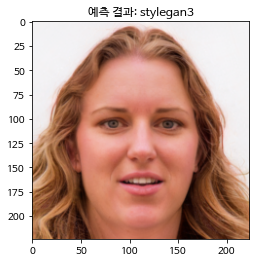

[예측 결과: stylegan3] (실제 정답: stylegan3)


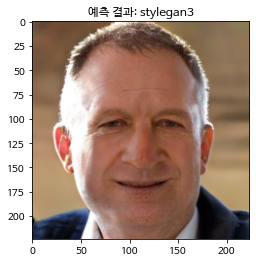

[예측 결과: stylegan3] (실제 정답: real_image)


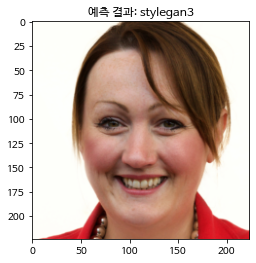

[예측 결과: real_image] (실제 정답: real_image)


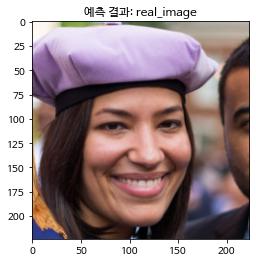

[Test Phase] Loss: 0.9307 Acc: 71.4286% Time: 1.8995s


In [29]:
model.eval()
start_time = time.time()

with torch.no_grad():
    running_loss = 0.
    running_corrects = 0

    for inputs, labels in test_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

        # 한 배치의 첫 번째 이미지에 대하여 결과 시각화
        print(f'[예측 결과: {class_names[preds[0]]}] (실제 정답: {class_names[labels.data[0]]})')
        imshow(inputs.cpu().data[0], title='예측 결과: ' + class_names[preds[0]])

    epoch_loss = running_loss / len(test_datasets)
    epoch_acc = running_corrects / len(test_datasets) * 100.
    print('[Test Phase] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch_loss, epoch_acc, time.time() - start_time))

## 여기까지가 분류 모델임
train 각각 47장, test 10장씩으로 돌린 결과
정확도 71.4286% 분류모델 생성되었음.
